In [1]:
import re
import glob
import matplotlib.pyplot as plt
from itertools import cycle
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator

plt.style.use('ggplot')

In [2]:
def get_event(file: str):
    event = EventAccumulator(file)
    event.Reload()
    return event

In [3]:
def get_log_metric(event: EventAccumulator, metric: str):
    
    _, step, value = zip(*event.Scalars(metric))
    
    return step, value

In [4]:
def plot_and_save_metrics(files: list, metric: str, path_prefix: str, filename: str):
    color_codes = map('C{}'.format, cycle(range(len(files))))
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 10))
    
    for file in files:
        label = re.sub(path_prefix, "", file)
        label = re.sub(r"/version_\d+/", "", label)
        event = get_event(file)
        step, value = get_log_metric(event, metric)
        plt.plot(
            step,
            value,
            color=next(color_codes),
            label=label
        )

    ax.legend(loc='upper right', fontsize='large')
    ax.set_ylabel(metric)
    ax.set_xlabel('epoch')
    plt.show()

    fig.savefig(
        f'../images/results/{filename}.png',
        transparent=False,
        dpi=400,
        bbox_inches="tight"
    )

In [5]:
path_prefix = "../data/logs/grid_logs_with_acc/"
filepath = f'{path_prefix}*'
files = glob.glob(
    filepath + '/**/version_*/',
    recursive=True
)
len(files)

81

In [6]:
metrics = [
    "avg_training_loss",
    "avg_validation_loss",
    "avg_training_acc",
    "avg_validation_acc"    
]
configs = {
    "batch_var": {
        "files": [f for f in files if "64" in f and "0.1" in f and "0.001" in f],
        "filename": "batch_var_{metric}"
    },
    "hidden_dim_var": {
        "files": [f for f in files if "512" in f and "0.1" in f and "0.001" in f],
        "filename": "hidden_dim_var_{metric}"
    },
    "dropout_var": {
        "files": [f for f in files if "512" in f and "64" in f and "0.001" in f],
        "filename": "dropout_var_{metric}"
    },
    "learning_rate_var": {
        "files": [f for f in files if "512" in f and "64" in f and "0.1" in f],
        "filename": "learning_rate_var_{metric}"
    }
}

batch_var
avg_training_loss
batch_var_avg_training_loss


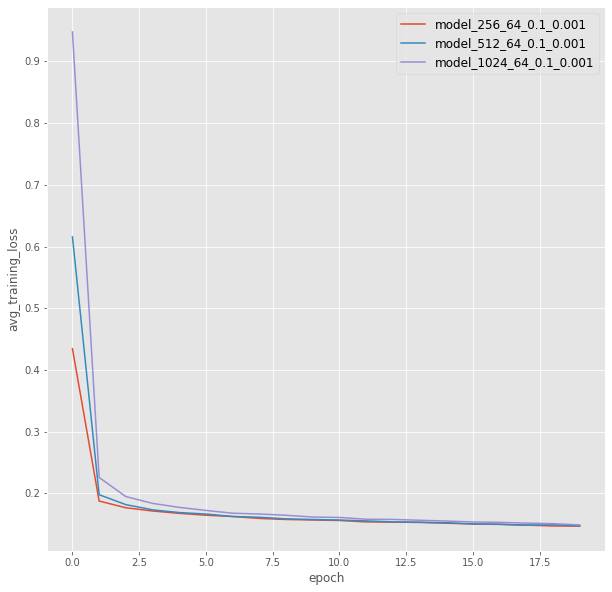

avg_validation_loss
batch_var_avg_validation_loss


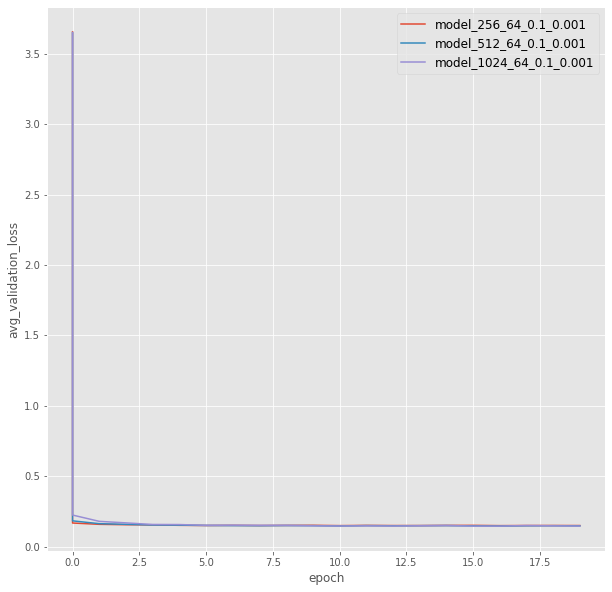

avg_training_acc
batch_var_avg_training_acc


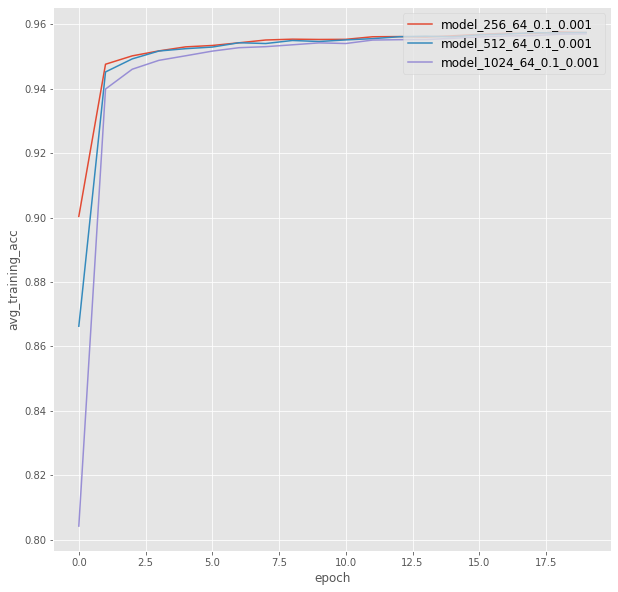

avg_validation_acc
batch_var_avg_validation_acc


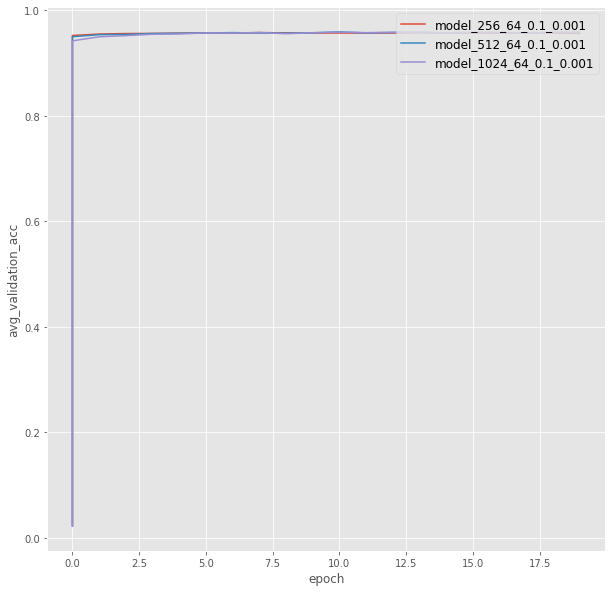

hidden_dim_var
avg_training_loss
hidden_dim_var_avg_training_loss


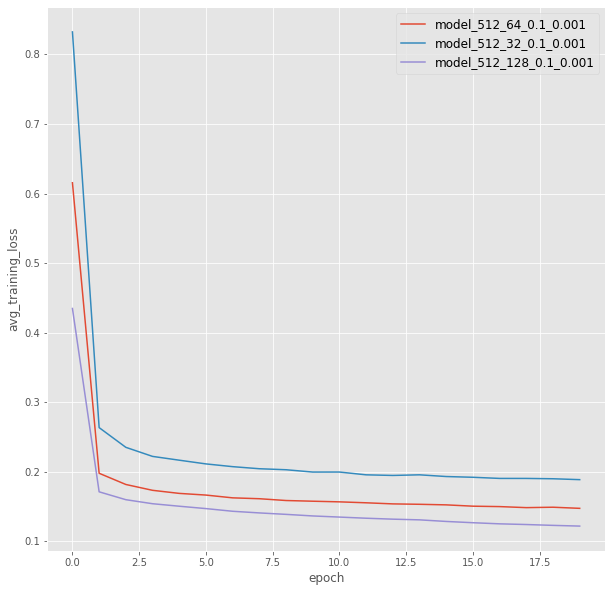

avg_validation_loss
hidden_dim_var_avg_validation_loss


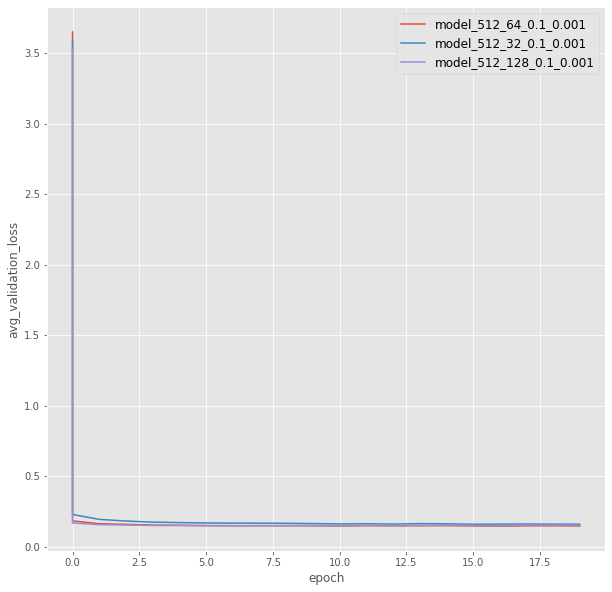

avg_training_acc
hidden_dim_var_avg_training_acc


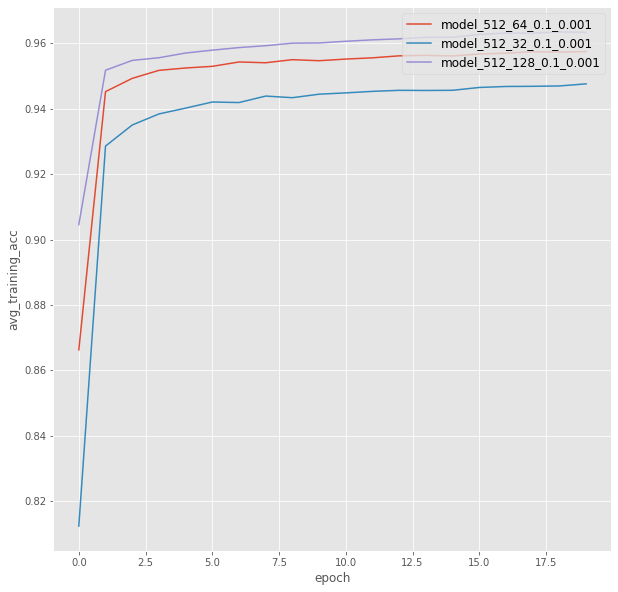

avg_validation_acc
hidden_dim_var_avg_validation_acc


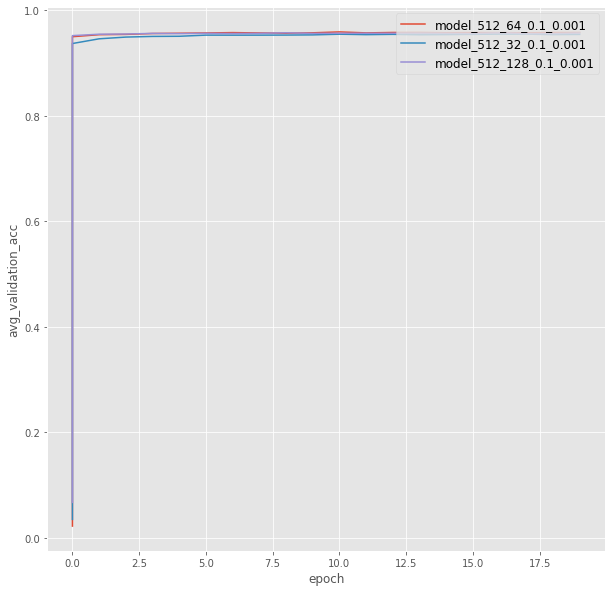

dropout_var
avg_training_loss
dropout_var_avg_training_loss


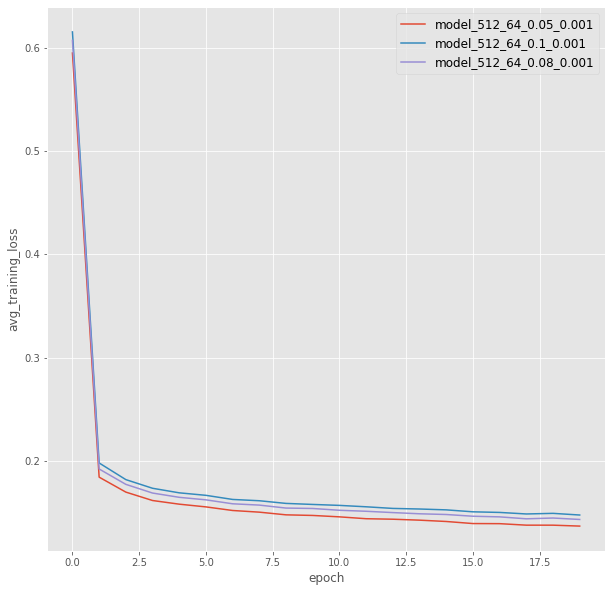

avg_validation_loss
dropout_var_avg_validation_loss


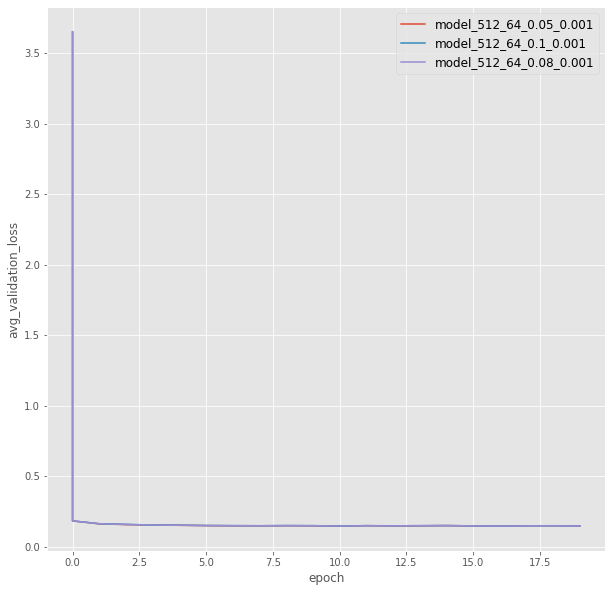

avg_training_acc
dropout_var_avg_training_acc


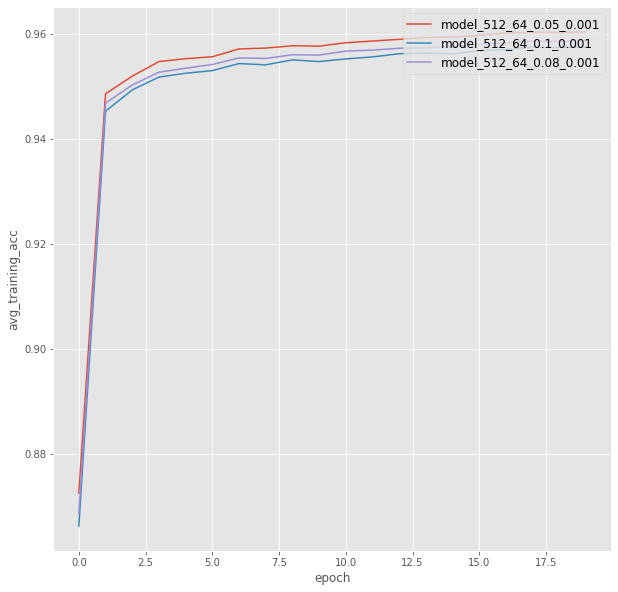

avg_validation_acc
dropout_var_avg_validation_acc


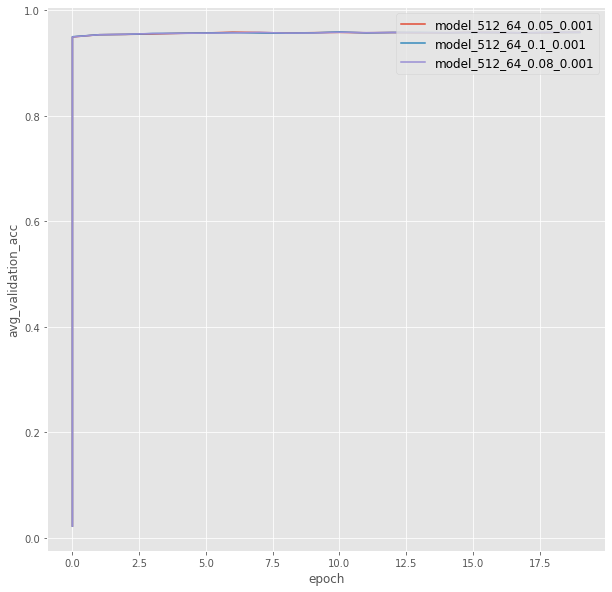

learning_rate_var
avg_training_loss
learning_rate_var_avg_training_loss


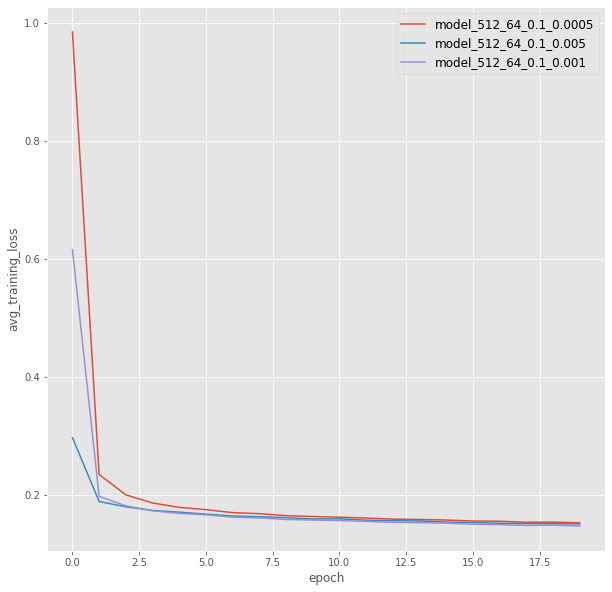

avg_validation_loss
learning_rate_var_avg_validation_loss


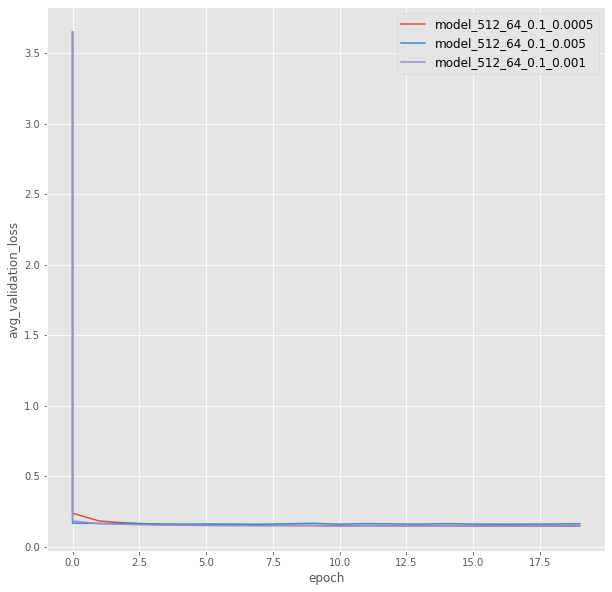

avg_training_acc
learning_rate_var_avg_training_acc


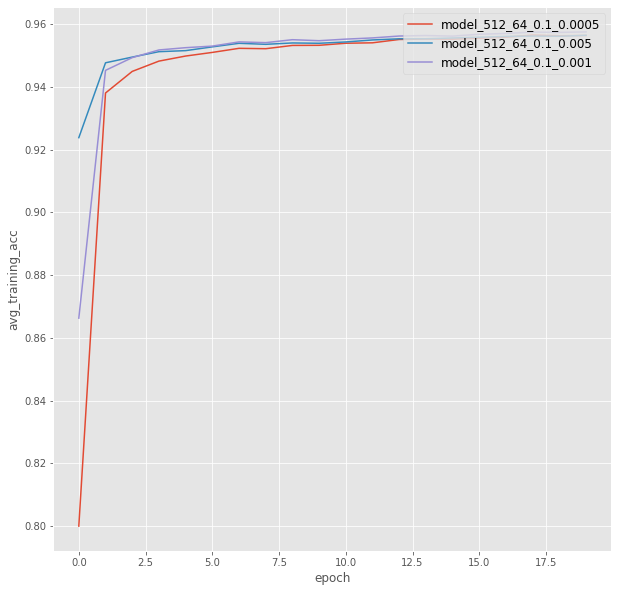

avg_validation_acc
learning_rate_var_avg_validation_acc


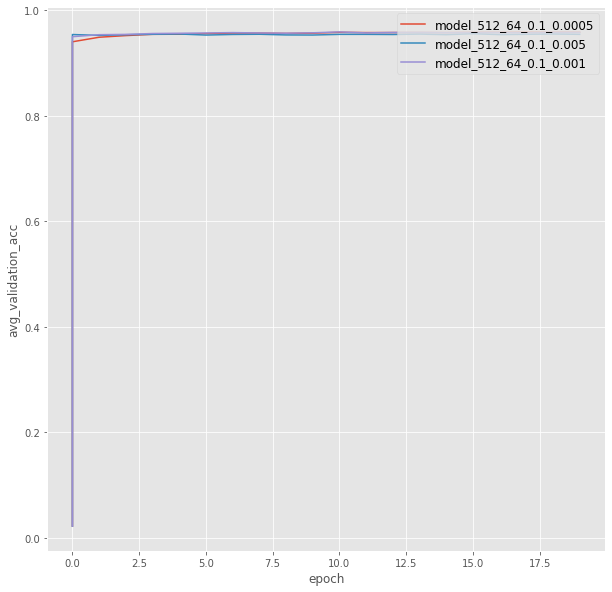

In [7]:
for c in configs.keys():
    print(c)
    for metric in metrics:
        print(metric)
        print(configs[c]["filename"].format(metric=metric))
        plot_and_save_metrics(
            configs[c]["files"],
            metric,
            path_prefix,
            configs[c]["filename"].format(metric=metric)
        )